## やってみたいこと
MINSTデータを`tf.data'でデータセット化し、逐次Augmentationしながらスタックオートエンコーダを学習させる  
→オートエンコーダの復元誤差検証と、復元データの正確性をクラスタリングで評価する

---

Jupyterの常套手段 `import`系の構文をど頭に書いておく  
→後で別のライブラリが必要になった時、ここだけ読み込めばよい

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import sklearn
import tensorflow as tf

from scipy import ndimage
from sklearn.cluster import KMeans
from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
#from sklearn.preprocessing import MinMaxScaler,minmax_scale
from sklearn.utils import check_random_state

print ("Numpy version:{0}".format(np.__version__))
print ("Scipy version:{0}".format(scipy.__version__))
print ("Scikit-Learn version:{0}".format(sklearn.__version__))
print ("Tensorflow version:{0}".format(tf.__version__))
print ("tf.keras version:{0}".format(tf.keras.__version__))

Numpy version:1.19.2
Scipy version:1.5.2
Scikit-Learn version:0.23.2
Tensorflow version:2.3.0
tf.keras version:2.4.0


---

### データの読み込み
 `numpy.nparray`との変換性検証の為、`keras`ではなく`sklearn`からMINSTをフェッチする

In [2]:
class Data_fetch:
    def __init__(self):
        self.random_state = check_random_state(0)

    def proc_minst_fetch(self):
        X, y = fetch_openml('mnist_784', version=1, return_X_y=True)

        pmt = self.random_state.permutation(X.shape[0])
        X = X[pmt]
        y = y[pmt]

        X_train,X_test,y_train,y_test = train_test_split(
            X,y,test_size=0.05
        )

        print(
            "MNIST fetched. Number of training data = {0} , test data = {1}"
            .format(len(X_train),len(X_test))
        )

        return X_train.reshape(-1,28,28),X_test.reshape(-1,28,28),y_test    #y_trainは使用しない kerasに合わせてreshapeしておく


---

### データパイプライン構築 
Augmentation処理として、ガウスノイズの付与とイメージの回転を行う

In [3]:
class Dataset_pipeline:
    def __init__(self):
        pass

    #ガウシアンノイズの付与
    def add_gause_noize(self,X):
        return X + (np.random.randn(28,28) * 20 )

    #画像の回転
    def rotate_image(self,X):
        return ndimage.rotate(X,np.random.uniform(-30.30), reshape = False)

    #一つの関数にまとめる(tf関数化の前処理)
    def augment_image(self,X):
        return self.add_gause_noize(self.rotate_image(X))

    #tf関数に変換
    @tf.function
    def tf_image_aug(self,X):
        x = tf.py_function(self.augment_image,[X],[tf.float32])
        return x[0]

    #データパイプライン
    def proc_dataset(self,X):
        x = tf.data.Dataset.from_tensor_slices(X).shuffle(len(X)).map(
            self.tf_image_aug,num_parallel_calls = tf.data.experimental.AUTOTUNE
            ) #2.4以後はtf.data.AUTOTUNE
        return x.prefetch(1)


---

### リカレントオートエンコーダ(動作未検証)  
入力段に`tf.keras.layers.GaussianNoise`をつけて、ノイズ除去オートエンコーダとして学習させる

In [20]:
class Rec_AE:
    def __init__(self):
        self.dp = Dataset_pipeline()
        self.monitor = "loss"
        self.epochs = 100
        self.X_train = X_train
        self.X_test = X_test

    #リカレントオートエンコーダ 入力段にガウスノイズを付与
    def def_rc(self):
        encoder = tf.keras.models.Sequential([
            tf.keras.layers.GaussianNoise(1.0,input_shape = [None,28]),
            tf.keras.layers.LSTM(14,return_sequences = True),
            tf.keras.layers.LSTM(7)
        ])

        decoder = tf.keras.models.Sequential([
            tf.keras.layers.RepeatVector(28,input_shape = [7]),
            tf.keras.layers.LSTM(14,return_sequences = True),
            tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(
                28,activation = "sigmoid"
                ))
        ])

        rec_ae = tf.keras.models.Sequential([encoder,decoder])

        rec_ae.compile(
            optimizer=tf.keras.optimizers.Nadam(),
            loss='binary_crossentropy',
            metrics=['accuracy']
        )

        return rec_ae

    #早期打ち切りコールバック
    def def_cb_earlystop(self,monitor):
        return tf.keras.callbacks.EarlyStopping(
            monitor = monitor,
            patience= 10,
            min_delta = 0.0001)

    #学習率減衰コールバック
    def def_cb_reduce(self,monitor):
        return tf.keras.callbacks.ReduceLROnPlateau(
            monitor = monitor,
            factor = 0.1,
            patience = 5,
            verbose= 1)

    #学習曲線の表示
    def elem_vis_learn_curve(self,hist):
        plt.subplot(121)
        plt.plot(hist.history['accuracy'])
        #plt.plot(hist.history['val_accuracy'])
        plt.ylabel("accuracy")
        plt.xlabel("epochs")
        #plt.legend(["Train","val"])
        plt.title("Accuracy")

        plt.subplot(122)
        plt.plot(hist.history['loss'])
        #plt.plot(hist.history['val_loss'])
        plt.ylabel("loss")
        plt.xlabel("epochs")
        #plt.legend(["Train","val"])
        plt.title("Loss")

        plt.show()


    #学習
    def proc_train_ae(self):
        train_set = self.dp.proc_dataset(self.X_train)
        model = self.def_rc()
        cb_es = self.def_cb_earlystop(monitor = self.monitor)
        cb_rd = self.def_cb_reduce(monitor = self.monitor)
        hist = model.fit(
            train_set, 
            #train_set,
            epochs = self.epochs,
            #validation_split = 0.05,
            shuffle = True,
            use_multiprocessing=True)

        model.summary()
        self.elem_vis_learn_curve(hist)

        return model

    #デコーダ
    def proc_dec_test(self,model):
        test_set = self.dp.proc_dataset(self.X_test)
        X_dec_tf = model.predict(test_set)
        return X_dec_tf.numpy() #出力は`numpy.nparray`で返す

In [21]:
df = Data_fetch()
X_train,X_test,y_test = df.proc_minst_fetch()
ae = Rec_AE()
model = ae.proc_train_ae()

MNIST fetched. Number of training data = 66500 , test data = 3500
Epoch 1/100


ValueError: in user code:

    C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:806 train_function  *
        return step_function(self, iterator)
    C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:796 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:789 run_step  **
        outputs = model.train_step(data)
    C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:757 train_step
        self.trainable_variables)
    C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:2737 _minimize
        trainable_variables))
    C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:562 _aggregate_gradients
        filtered_grads_and_vars = _filter_grads(grads_and_vars)
    C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:1271 _filter_grads
        ([v.name for _, v in grads_and_vars],))

    ValueError: No gradients provided for any variable: ['lstm_18/lstm_cell_18/kernel:0', 'lstm_18/lstm_cell_18/recurrent_kernel:0', 'lstm_18/lstm_cell_18/bias:0', 'lstm_19/lstm_cell_19/kernel:0', 'lstm_19/lstm_cell_19/recurrent_kernel:0', 'lstm_19/lstm_cell_19/bias:0', 'lstm_20/lstm_cell_20/kernel:0', 'lstm_20/lstm_cell_20/recurrent_kernel:0', 'lstm_20/lstm_cell_20/bias:0', 'time_distributed_3/kernel:0', 'time_distributed_3/bias:0'].


---

### k平均法クラスタリングによる評価(動作未検証)

In [ ]:
class Clustering:
    def __init__(self):
        self.X_train = X_train
        self.X_test = X_test
        self.X_dec = X_dec
        self.cls = kmeans(n_clusters= 9)
        self.pca = PCA(n_components=3)

    #X_trainをクラスタリング
    def elem_act_cls(self):
        return self.cls.fit(X_train)
    
    #クラスタセンタの描画
    def vis_cluster_center(self,model):
        fig,axis = plt.subplots(1,10,subplot_kw = "xticks":(),"yticks":())
        for center,ax in zip(model.cluster_centers_,axis.ravel()):
            ax.imshow(center,vmin = 0,vmax = 255)
        plt.show()

    #AE通過後のデータを評価
    def elem_test_clustering(self,model):
        y_pred = model.predict(self.X_dec)

        

---

## わかったこと
- `tf.data.Dataset.map()`でAugmentationする場合、`map()`の中に指定できるtf関数は一つだけ。  
    →複数の処理を行う場合、個別の処理を定義→それらをまとめた関数を定義→`@tf.function`と`tf.py_function()`でラップする必要がある
- データセットクラスを学習クラスから呼び出せば、データセットの中間生成物を保存することなく学習が行える
- `keras`にデータセットを流し込む場合、`keras`側の`fit()`の引数に`y`は必要ない
- `keras`にデータセットを流し込む場合、`keras`側の`fit()`の引数に`validation_split =` は使用できない

---

以下、動作検証コード

- Augmentationの動作確認

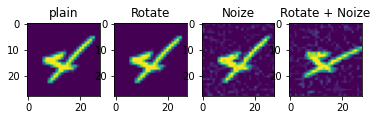

In [12]:
df = Data_fetch()
X_train,X_test,y_test = df.proc_minst_fetch()
ap = Dataset_pipeline()
X_img = X_train[0]
plt.subplot(1,4,1)
plt.imshow(X_img,vmin = 0,vmax = 255)
plt.title("plain")
plt.subplot(1,4,2)
plt.imshow(ap.rotate_image(X_img),vmin = 0,vmax = 255)
plt.title("Rotate")
plt.subplot(1,4,3)
plt.imshow(ap.add_gause_noize(X_img),vmin = 0,vmax = 255)
plt.title("Noize")
plt.subplot(1,4,4)
plt.imshow(ap.add_gause_noize(ap.rotate_image(X_img)),vmin = 0,vmax = 255)
plt.title("Rotate + Noize")

plt.show()


- データセットの動作検証

MNIST fetched. Number of training data = 66500 , test data = 3500


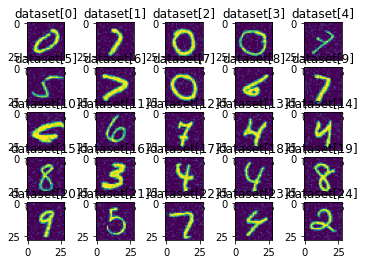

In [11]:
df = Data_fetch()
X_train,X_test,y_test = df.proc_minst_fetch()
ap = Dataset_pipeline()
dataset = ap.proc_dataset(X_train)
for i in range(25):
    img = next(iter(dataset)).numpy()
    plt.subplot(5,5,i + 1)
    plt.imshow(img,vmin = 0,vmax = 255)
    plt.title("dataset[{0}]".format(i))
plt.show()